#### In this notebook, we show an end-to-end demo of rapids dask-cudf + dask-glm on mutliple GPUs. Experiments are done on a `DGX-1` with `8xGPUs` and `40-core CPUs`. With the HIGGS dataset, the GPU solution achieves `14x` speedup over CPU using the `lbfgs` solver. To get a more comprehensive speedup measurement, we vary the size of random synthetic data and the GPU solution achieves up to `27x` speedup over CPU.

### Table of contents
[1. Introduction](#bg)<br>
[2. Install instructions](#install)<br>
[3. Libraries and helper functions](#lib)<br>
[4. Dask glm on GPU](#gpu)<br>
[5. Dask glm on CPU](#cpu)<br>
[6. Speedup and Conclusion](#speedup)<br>

### Introduction
<a id="bg"></a>
**Multi-GPU support of dask-glm is enabled by recent efforts of allowing cupy dask arrays as inputs.** [dask/dask-glm#87](https://github.com/dask/dask-glm/pull/87) and [dask/dask-glm#89](https://github.com/dask/dask-glm/pull/89)

dask-glm offers 3 estimators:
- LinearRegression
- LogisticRegression
- PoissonRegression

and 5 solvers:
- admm,
- gradient_descent,
- newton,
- lbfgs,
- proximal_grad

Currently, all 3 estimators and 5 algorithms work seamlessly with `dask-cudf` on multiple GPUs. 

In this demo, we use `LogisticRegression` to solve a binary classification problem on multiple GPUs.
<br>Performance is compared on a DGX station with a 20-core CPU and 4xV100 GPUs. **The GPU dask achieves 8x speedup of the CPU counterpart.**

### Install instructions:
<a id="install"></a>

- conda create -n rapids-0.17 -c rapidsai-nightly -c nvidia -c conda-forge -c defaults rapids=0.17 python=3.7 cudatoolkit=10.2
- conda activate rapids-0.17    
- pip install git+https://github.com/dask/dask
- git clone https://github.com/dask/dask-glm
- cd dask-glm
- pip install -e .

We use cuda 10.2 in this demo. 

### Libraries and helper functions
<a id="lib"></a>

In [1]:
import os
GPU_id = '0,1,2,3,4,5,6,7'
os.environ['CUDA_VISIBLE_DEVICES'] = GPU_id
os.environ["CUPY_EXPERIMENTAL_SLICE_COPY"] = "1"
num_gpus = len(GPU_id.split(','))

import warnings
warnings.filterwarnings("ignore")

In [2]:
import dask.dataframe as dd
from dask_glm.estimators import LogisticRegression
from dask_glm.datasets import make_classification

import time
import dask_glm
import dask
import numpy as np
import cupy as cp

import dask_cudf
from dask.distributed import Client, wait, LocalCluster
from dask_cuda import LocalCUDACluster
import dask.array as da

print('dask', dask.__version__) # 
print('dask_glm', dask_glm.__version__) # 
print('cupy', cp.__version__) #
print('dask_cudf', dask_cudf.__version__)

dask 2.30.0+57.g3e264491
dask_glm 0.2.1.dev52+g1daf4c5
cupy 8.1.0
dask_cudf 0.17.0a+265.g42fe2183f7


In [3]:
def get_run_time(solver,min_samples,max_samples,data_type='cupy'):
    times = []
    for n in range(min_samples,max_samples+1):
        n_samples=10**n
        n_features = 20
        chunks = num_gpus if data_type=='cupy' else 80 # dgx-1 has 40 cores and 80 hyperthreads
        
        dx, dy = make_classification(n_samples=n_samples, n_features=n_features, n_informative=10, chunksize=n_samples//chunks)
        #dx = dx.astype('float32')
        if data_type=='cupy':
            dx, dy = to_cupy(dx, dy)
        dx, dy = dask.persist(dx, dy)
        wait(dx)
        wait(dy)
        start = time.time()
        lr = LogisticRegression(solver=solver, max_iter=2)
        lr.fit(dx,dy)
        duration = time.time()-start
        del dx,dy
        del lr
        times.append(duration)
        print('%s samples:10^%d time:%.2f'%(solver,n,duration))
    return times

def to_cupy(X, y):
    X = X.map_blocks(lambda x: cp.asarray(x),
                         dtype=X.dtype, meta=cp.asarray(X._meta))
    y = y.map_blocks(lambda x: cp.asarray(x),
                     dtype=y.dtype, meta=cp.asarray(y._meta))
    return X,y

### Dask-glm on GPU
<a id="gpu"></a>

In [4]:
cluster = LocalCUDACluster(protocol="ucx", 
                           enable_tcp_over_ucx=True, enable_nvlink=True)
client = Client(cluster)
client

Client Scheduler: ucx://127.0.0.1:57555 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 1.08 TB


There arer 8xV100 GPUs in dgx-1. `dask-cudf` is used to read data.

In [5]:
%%time
# download data from:
# https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

fname = '/raid/data/ml/higgs/HIGGS.csv'
colnames = ['label'] + ['feature-%02d' % i for i in range(1, 29)]

dask_df = dask_cudf.read_csv(fname, header=None, names=colnames)

ddf = dask_df.repartition(npartitions=num_gpus) # set it to the number of GPUs for best performance
ddf.head()

CPU times: user 1.06 s, sys: 463 ms, total: 1.53 s
Wall time: 3.75 s


,label,feature-01,feature-02,feature-03,feature-04,feature-05,feature-06,feature-07,feature-08,feature-09,...,feature-19,feature-20,feature-21,feature-22,feature-23,feature-24,feature-25,feature-26,feature-27,feature-28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [6]:
%%time
print('number of samples:', len(ddf))
print('number of features:', ddf.shape[1])

number of samples: 11000000
number of features: 29
CPU times: user 302 ms, sys: 70.5 ms, total: 372 ms
Wall time: 3.59 s


In [7]:
%%time
print(f"mean target:{ddf['label'].mean().compute():.3f}")

mean target:0.530
CPU times: user 340 ms, sys: 54.3 ms, total: 394 ms
Wall time: 2.35 s


**So there are 11M samples and 28 numerical features**. The target column `label` is binary and it is pretty balanced.

In [8]:
%%time
print(len(ddf), ddf.npartitions)
y = ddf['label']
X = ddf[ddf.columns.difference(['label'])]

X

11000000 8
CPU times: user 260 ms, sys: 20.8 ms, total: 281 ms
Wall time: 2.47 s


,feature-01,feature-02,feature-03,feature-04,feature-05,feature-06,feature-07,feature-08,feature-09,feature-10,feature-11,feature-12,feature-13,feature-14,feature-15,feature-16,feature-17,feature-18,feature-19,feature-20,feature-21,feature-22,feature-23,feature-24,feature-25,feature-26,feature-27,feature-28
npartitions=8,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Unfortunately `dask.dataframe` is not accepted by `dask-glm` at the moment. We have to convert them to arrays. 

In [9]:
%%time
# convert dask dataframes to dask arrays
Xa = X.values
ya = y.values

Xa

CPU times: user 8.79 ms, sys: 494 µs, total: 9.28 ms
Wall time: 7.56 ms


dask.array<values, shape=(nan, 28), dtype=float64, chunksize=(nan, 28), chunktype=numpy.ndarray>

We make two observations:
- the chunk type is incorrect. it is supposed to be `cupy.ndarray`
- the chunk shape is `nan`.

Both of these lead to errors when we feed these data to `dask-glm`

**Fix the chunk type**

In [10]:
%%time
# Make the chunk type cupy
Xa._meta = cp.asarray(Xa._meta)
ya._meta = cp.asarray(ya._meta)

CPU times: user 359 µs, sys: 0 ns, total: 359 µs
Wall time: 263 µs


**Compute the chunk shape**

In [11]:
%%time
Xa.compute_chunk_sizes()
ya.compute_chunk_sizes()
Xa

CPU times: user 409 ms, sys: 129 ms, total: 538 ms
Wall time: 4.77 s


dask.array<values, shape=(11000000, 28), dtype=float64, chunksize=(1469876, 28), chunktype=cupy.ndarray>

In [12]:
%%time

Xa, ya = dask.persist(Xa, ya)
wait(Xa)
_ = wait(ya)

CPU times: user 226 ms, sys: 10.9 ms, total: 236 ms
Wall time: 2.11 s


In [13]:
%%time
start = time.time()
lr = LogisticRegression(solver='lbfgs', max_iter=10)
lr.fit(Xa, ya)
yp = lr.predict(Xa)
acc = (yp==ya).mean().compute()
print('Training Accuracy %.3f'%acc)
gpu_higgs_time = time.time() - start

Training Accuracy 0.641
CPU times: user 2.55 s, sys: 341 ms, total: 2.89 s
Wall time: 5.36 s


**It took only `5` seconds to train and predict 11M samples!** As we will see below, it is **14x speedup** over the CPU solution.

**We also record the running time on random synthetic data with increasing sizes.**

In [14]:
%%time

# record the running time on random synthetic data

solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
cupy_time = {}
for s in solvers:
    cupy_time[s] = get_run_time(s,3,8,data_type='cupy')

admm samples:10^3 time:1.15
admm samples:10^4 time:0.75
admm samples:10^5 time:0.34
admm samples:10^6 time:0.66
admm samples:10^7 time:2.11
admm samples:10^8 time:4.18
lbfgs samples:10^3 time:0.61
lbfgs samples:10^4 time:0.64
lbfgs samples:10^5 time:0.64
lbfgs samples:10^6 time:0.81
lbfgs samples:10^7 time:1.02
lbfgs samples:10^8 time:4.65
newton samples:10^3 time:1.08
newton samples:10^4 time:0.76
newton samples:10^5 time:1.11
newton samples:10^6 time:0.67
newton samples:10^7 time:1.07
newton samples:10^8 time:4.64
proximal_grad samples:10^3 time:1.17
proximal_grad samples:10^4 time:1.54
proximal_grad samples:10^5 time:1.74
proximal_grad samples:10^6 time:1.86
proximal_grad samples:10^7 time:3.41
proximal_grad samples:10^8 time:11.07
gradient_descent samples:10^3 time:1.07
gradient_descent samples:10^4 time:2.05
gradient_descent samples:10^5 time:1.30
gradient_descent samples:10^6 time:1.51
gradient_descent samples:10^7 time:2.73
gradient_descent samples:10^8 time:8.50
CPU times: user

### Dask glm on CPU
<a id="cpu"></a>

In [15]:
# dask glm cpu baseline
cluster = LocalCluster(n_workers=80)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44291 Dashboard: http://127.0.0.1:34975/status,Cluster Workers: 80 Cores: 80 Memory: 1.08 TB


The CPU has 40 cores and 80 hyperthreads on `dgx-1`.

In [16]:
%%time

dask_df = dd.read_csv(fname, header=None, names=colnames)
dask_df = dask_df.repartition(npartitions=80) # one partition per thread

print(len(dask_df), dask_df.npartitions)
y = dask_df['label']
X = dask_df[dask_df.columns.difference(['label'])]

Xa = X.values
ya = y.values

Xa.compute_chunk_sizes()
ya.compute_chunk_sizes()

Xa, ya = dask.persist(Xa, ya)
wait(Xa)
wait(ya)

Xa

11000000 80
CPU times: user 10 s, sys: 5.08 s, total: 15.1 s
Wall time: 17.3 s


dask.array<values, shape=(11000000, 28), dtype=float64, chunksize=(175225, 28), chunktype=numpy.ndarray>

In [17]:
%%time
start = time.time()
lr = LogisticRegression(solver='lbfgs', max_iter=10)
lr.fit(Xa, ya)
yp = lr.predict(Xa)
acc = (yp==ya).mean().compute()
print('Training Accuracy %.3f'%acc)
cpu_higgs_time = time.time() - start

Training Accuracy 0.641
CPU times: user 35.1 s, sys: 10.9 s, total: 46 s
Wall time: 1min 17s


We see the same training accuracy but much longer running time. The GPU solution achieves **14x speedup** over the CPU solution

In [18]:
%%time
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
numpy_time = {}
for s in solvers:
    numpy_time[s] = get_run_time(s,3,8,data_type='numpy')

admm samples:10^3 time:2.77
admm samples:10^4 time:2.56
admm samples:10^5 time:11.52
admm samples:10^6 time:18.70
admm samples:10^7 time:67.78
admm samples:10^8 time:112.42
lbfgs samples:10^3 time:5.53
lbfgs samples:10^4 time:4.97
lbfgs samples:10^5 time:10.91
lbfgs samples:10^6 time:16.17
lbfgs samples:10^7 time:17.40
lbfgs samples:10^8 time:30.37
newton samples:10^3 time:6.44
newton samples:10^4 time:5.72
newton samples:10^5 time:14.82
newton samples:10^6 time:15.42
newton samples:10^7 time:17.69
newton samples:10^8 time:41.66
proximal_grad samples:10^3 time:10.75
proximal_grad samples:10^4 time:11.87
proximal_grad samples:10^5 time:26.34
proximal_grad samples:10^6 time:44.72
proximal_grad samples:10^7 time:59.58
proximal_grad samples:10^8 time:85.97
gradient_descent samples:10^3 time:8.89
gradient_descent samples:10^4 time:9.92
gradient_descent samples:10^5 time:21.62
gradient_descent samples:10^6 time:26.06
gradient_descent samples:10^7 time:32.00
gradient_descent samples:10^8 time

### Speedup and Conclusion
<a id="speedup"></a>

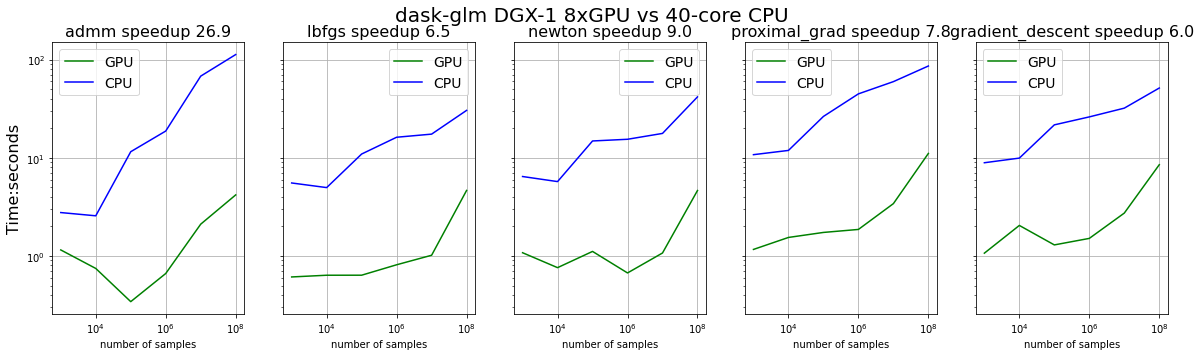

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,5, figsize=(20, 5),sharex=True,sharey=True)
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
speedup = [numpy_time[s][-1]/cupy_time[s][-1] for s in solvers]
nsamples = [10**i for i in range(3,9)]
axs[0].set_ylabel("Time:seconds",fontsize=16)
plt.suptitle("dask-glm DGX-1 8xGPU vs 40-core CPU", fontsize=20)

for c,s in enumerate(solvers):
    axs[c].plot(nsamples,cupy_time[s],color='g',label='GPU')
    axs[c].plot(nsamples,numpy_time[s],color='b',label='CPU')
    axs[c].set_xscale("log")
    axs[c].set_yscale("log")
    axs[c].grid()
    axs[c].set_title('%s speedup %.1f'%(s, speedup[c]),fontsize=16)
    axs[c].set_xlabel("number of samples",)
    axs[c].legend(fontsize=14)

#plt.savefig("dask_glm_cupy_vs_numpy.pdf",format='pdf',quality=95)

This notebook shows how `dask-cudf` works with `dask-glm` as the downstream classifiers. The key takeaway is to convert `dask cudf dataframes` to `dask arrays with cupy chunks`. A decent speedup is achieved with minimal code changes.